In [2]:
# ============================================
# DATASET LOADING & CLEANING  (ATP 2000–2025)
# ============================================

import os
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")

# 1️⃣  Resolve base and data directory (portable for GitHub/Streamlit)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "tennis_atp")

# 2️⃣  Ensure data folder exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(
        f"Expected folder 'tennis_atp' not found in {BASE_DIR}. "
        "Please unzip the tennis_atp dataset into your project root."
    )

# 3️⃣  Load all yearly ATP match files (2000–2025)
files = sorted(glob.glob(os.path.join(DATA_DIR, "atp_matches_20*.csv")))
if not files:
    raise FileNotFoundError("No ATP match CSVs found inside tennis_atp/")

# 4️⃣  Combine all years into one DataFrame
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 5️⃣  Convert integer-style dates (e.g., 20071015) to datetime
df["tourney_date"] = pd.to_datetime(df["tourney_date"].astype(str), format="%Y%m%d", errors="coerce")

# 6️⃣  Drop invalid or incomplete rows
df = df.dropna(subset=["winner_name", "loser_name", "tourney_date"])

# 7️⃣  Keep only modern-era matches (2000–2025)
df = df[(df["tourney_date"].dt.year >= 2000) & (df["tourney_date"].dt.year <= 2025)]

# 8️⃣  Output sanity check
print(f"✅ Loaded {len(df):,} matches spanning "
      f"{df['tourney_date'].min().date()} → {df['tourney_date'].max().date()}")

# Optional quick look
df[['tourney_date', 'surface', 'winner_name', 'loser_name', 'score']].head()

✅ Loaded 74,906 matches spanning 2000-01-03 → 2024-12-18


,tourney_date,surface,winner_name,loser_name,score
0,2000-01-10,Hard,Tommy Haas,Jeff Tarango,7-5 4-6 7-5
1,2000-01-10,Hard,Juan Balcells,Franco Squillari,7-5 7-5
2,2000-01-10,Hard,Alberto Martin,Alberto Berasategui,6-3 6-1
3,2000-01-10,Hard,Juan Carlos Ferrero,Roger Federer,6-4 6-4
4,2000-01-10,Hard,Michael Sell,Nicolas Escude,0-6 7-6(7) 6-1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          74906 non-null  object        
 1   tourney_name        74906 non-null  object        
 2   surface             74853 non-null  object        
 3   draw_size           74906 non-null  int64         
 4   tourney_level       74906 non-null  object        
 5   tourney_date        74906 non-null  datetime64[ns]
 6   match_num           74906 non-null  int64         
 7   winner_id           74906 non-null  int64         
 8   winner_seed         31120 non-null  float64       
 9   winner_entry        9506 non-null   object        
 10  winner_name         74906 non-null  object        
 11  winner_hand         74906 non-null  object        
 12  winner_ht           73481 non-null  float64       
 13  winner_ioc          74906 non-null  object    

In [4]:
# ============================================
# HANDLE MISSING SURFACE VALUES
# ============================================

# Fill missing surface values with 'Unknown' for transparency
df["surface"] = (
    df["surface"]
    .fillna("Unknown")
    .astype(str)
    .str.strip()
    .str.title()
)

# Verify results
print("✅ Surface column cleaned successfully.")
print(df["surface"].value_counts(dropna=False))


✅ Surface column cleaned successfully.
surface
Hard       40871
Clay       24244
Grass       7699
Carpet      2039
Unknown       53
Name: count, dtype: int64


In [5]:
# ============================================
# ADVANCED ELO CALCULATION FOR TENNIS
# ============================================

import pandas as pd
from collections import defaultdict
import numpy as np

# ------------------------------------------------------------
# 1️⃣  Create surface code mapping (run once before Elo)
# ------------------------------------------------------------
surface_map = {
    "Hard": "H",
    "Clay": "C",
    "Grass": "G",
    "Carpet": "O",
    "Unknown": "UNK"
}
df["surface_code"] = df["surface"].map(surface_map).fillna("UNK")

# ------------------------------------------------------------
# 2️⃣  Elo function
# ------------------------------------------------------------
def compute_elo_advanced(
    df,
    base_elo=1500,
    K_base=32,
    surface_weight=True,
    match_importance=True,
    best_of_adjust=True,
    recency_decay=True,
    margin_adjust=False
):
    """
    Compute an advanced Elo rating system for tennis.

    Features:
        ✅ Surface-specific Elo tracking
        ✅ Tournament-level weighting (importance)
        ✅ Best-of-5 vs Best-of-3 adjustment
        ✅ Recency decay
        ✅ Variable K-factor
        ⚙️ Optional margin-of-victory scaling
    """

    # Initialize Elo per player (optionally per surface)
    if surface_weight:
        elo = defaultdict(lambda: {"H": base_elo, "C": base_elo, "G": base_elo,
                                   "O": base_elo, "UNK": base_elo})
    else:
        elo = defaultdict(lambda: {"ALL": base_elo})

    # Tournament weighting
    level_weights = {
        "G": 1.25,  # Grand Slam
        "M": 1.1,   # Masters
        "A": 1.0,   # ATP 500/250
    }

    winner_elos, loser_elos = [], []
    df = df.sort_values("tourney_date").reset_index(drop=True)

    for _, row in df.iterrows():
        w, l = row["winner_name"], row["loser_name"]
        surf = row.get("surface_code", "UNK") if surface_weight else "ALL"

        # Retrieve current ratings
        w_elo, l_elo = elo[w][surf], elo[l][surf]

        # Base expected win probability
        expected_w = 1 / (1 + 10 ** ((l_elo - w_elo) / 400))
        K = K_base

        # (1) Match importance weighting
        if match_importance and pd.notna(row.get("tourney_level")):
            K *= level_weights.get(row["tourney_level"], 1.0)

        # (2) Best-of-5 adjustment
        if best_of_adjust and row.get("best_of", 3) == 5:
            K *= 1.2

        # (3) Recency decay (older matches matter less)
        if recency_decay:
            days_old = (df["tourney_date"].max() - row["tourney_date"]).days
            decay_factor = np.exp(-days_old / 3650)  # ≈10-year half-life
            K *= decay_factor

        # (4) Optional margin-of-victory scaling
        if margin_adjust and isinstance(row.get("score"), str):
            try:
                sets = row["score"].split()
                game_diff = np.mean([
                    abs(int(s.split('-')[0]) - int(s.split('-')[1]))
                    for s in sets if '-' in s
                ])
                K *= (1 + 0.03 * game_diff)
            except Exception:
                pass

        # Update ratings
        elo[w][surf] = w_elo + K * (1 - expected_w)
        elo[l][surf] = l_elo + K * (0 - (1 - expected_w))

        # Save pre-match ratings
        winner_elos.append(w_elo)
        loser_elos.append(l_elo)

    df["winner_elo"] = winner_elos
    df["loser_elo"] = loser_elos

    print("✅ Advanced Elo calculation complete.")
    return df


In [6]:
# ======================================================
# APPLY ADVANCED ELO FUNCTION TO MAIN DATAFRAME
# ======================================================

# Run the advanced Elo calculation
df = compute_elo_advanced(df)

# Quick sanity check
df[["tourney_date", "tourney_name", "surface", "tourney_level",
    "winner_name", "loser_name", "winner_elo", "loser_elo"]].head()


✅ Advanced Elo calculation complete.


,tourney_date,tourney_name,surface,tourney_level,winner_name,loser_name,winner_elo,loser_elo
0,2000-01-03,Adelaide,Hard,A,Lleyton Hewitt,Nicolas Escude,1500.0,1500.0
1,2000-01-03,Adelaide,Hard,A,Roger Federer,Jens Knippschild,1500.0,1500.0
2,2000-01-03,Adelaide,Hard,A,Thomas Enqvist,Arnaud Clement,1500.0,1500.0
3,2000-01-03,Doha,Hard,A,Nicolas Kiefer,Jeff Tarango,1500.0,1500.0
4,2000-01-03,Doha,Hard,A,Cristiano Caratti,Ivo Heuberger,1500.0,1500.0


In [7]:
df.tail(10)[["tourney_date", "winner_name", "winner_elo", "loser_name", "loser_elo"]]

,tourney_date,winner_name,winner_elo,loser_name,loser_elo
74896,2024-12-18,Learner Tien,1514.232158,Arthur Fils,1722.794209
74897,2024-12-18,Learner Tien,1543.747468,Jakub Mensik,1699.386868
74898,2024-12-18,Joao Fonseca,1563.036484,Jakub Mensik,1672.118533
74899,2024-12-18,Joao Fonseca,1588.074022,Learner Tien,1571.015804
74900,2024-12-18,Luca Van Assche,1475.134553,Nishesh Basavareddy,1500.000000
74901,2024-12-18,Nishesh Basavareddy,1479.428226,Juncheng Shang,1625.591395
74902,2024-12-18,Luca Van Assche,1495.706327,Juncheng Shang,1598.759150
74903,2024-12-18,Alex Michelsen,1635.576082,Nishesh Basavareddy,1506.260471
74904,2024-12-18,Alex Michelsen,1647.942519,Juncheng Shang,1574.025573
74905,2024-12-18,Joao Fonseca,1606.332106,Arthur Fils,1693.278898


In [8]:
# ============================================
# BUILD MONTHLY ELO TIME SERIES FOR ALL PLAYERS
# ============================================

def build_monthly_elo_all(df):
    """
    Creates a dictionary of monthly average Elo ratings for all players.
    Returns: dict[player_name] = pandas.Series (monthly Elo)
    """

    # Get unique players from both winner and loser columns
    players = pd.unique(df[["winner_name", "loser_name"]].values.ravel("K"))
    player_series = {}

    for player in players:
        # Extract matches involving this player
        p_df = df[(df["winner_name"] == player) | (df["loser_name"] == player)].copy()

        if p_df.empty:
            continue  # skip players with no matches

        # Assign Elo based on win/loss
        p_df["player_elo"] = np.where(
            p_df["winner_name"] == player,
            p_df["winner_elo"],
            p_df["loser_elo"]
        )

        # Resample to monthly average Elo
        p_monthly = (
            p_df.set_index("tourney_date")
            .resample("M")["player_elo"]
            .mean()
            .interpolate()
        )

        # Store series
        player_series[player] = p_monthly

    print(f"✅ Built monthly Elo series for {len(player_series)} players.")
    return player_series


# Build for all players
player_monthly_elo = build_monthly_elo_all(df)

# Example: view Djokovic's monthly series
print(player_monthly_elo["Novak Djokovic"].head())


✅ Built monthly Elo series for 2639 players.
tourney_date
2004-04-30    1500.000000
2004-05-31    1500.000000
2004-06-30    1500.000000
2004-07-31    1500.000000
2004-08-31    1499.709612
Freq: ME, Name: player_elo, dtype: float64


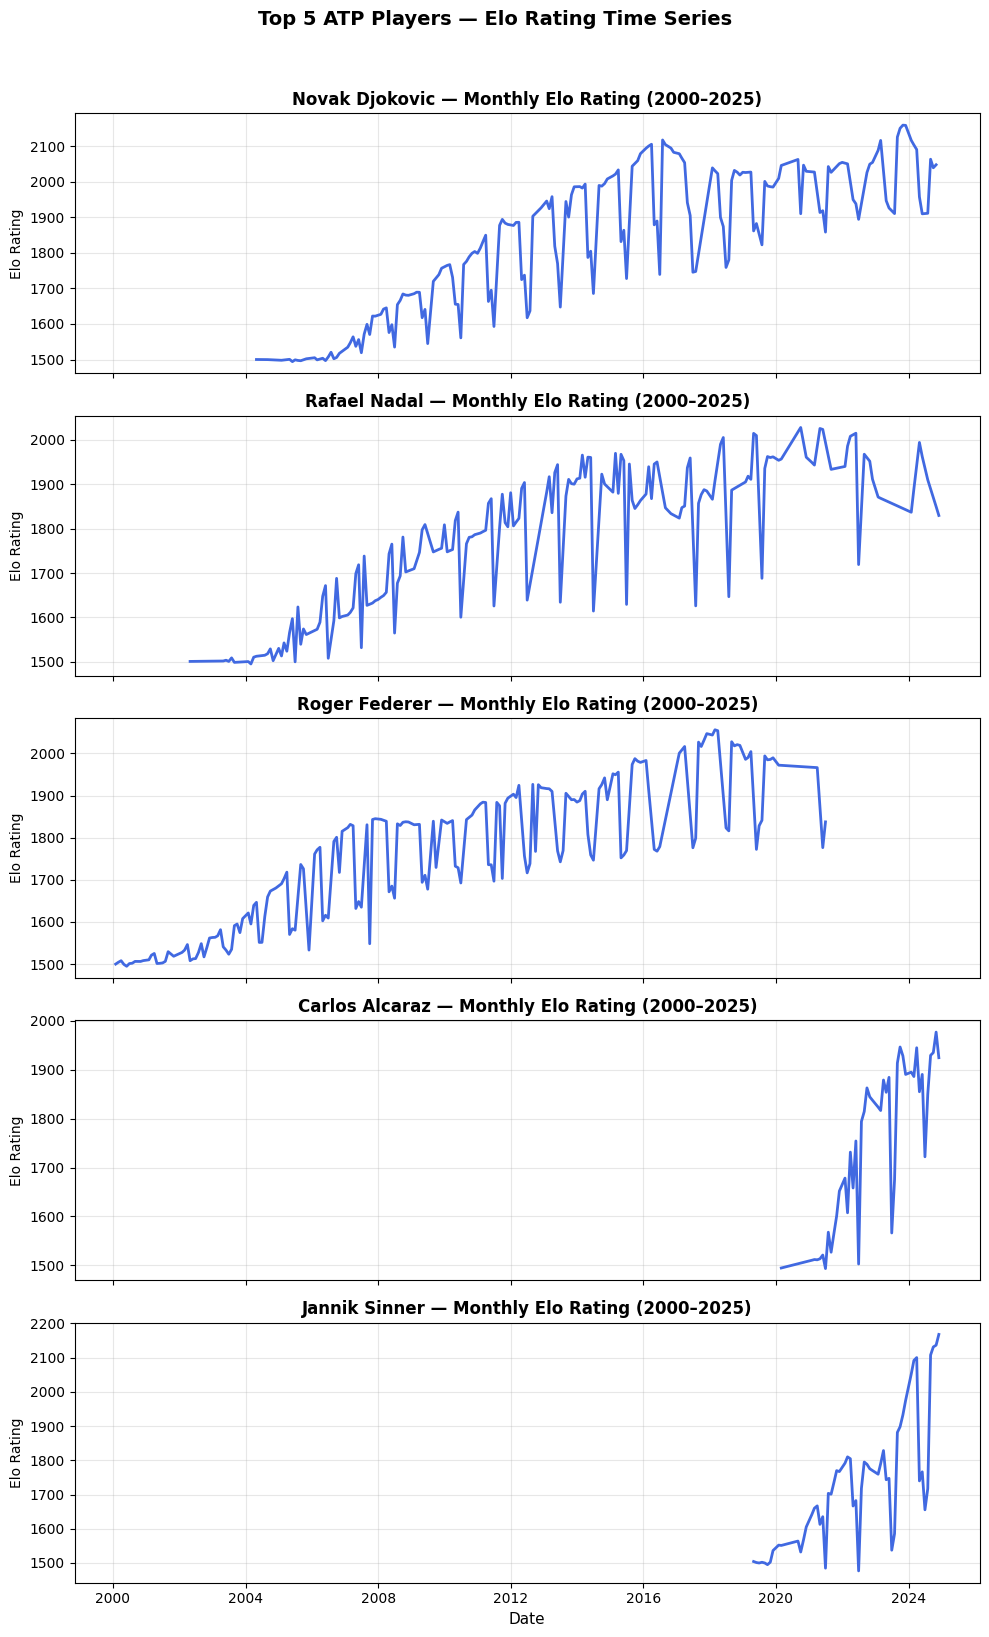

In [9]:
import matplotlib.pyplot as plt

# Define your representative players
top_players = ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Carlos Alcaraz", "Jannik Sinner"]

# Create subplots for each player
fig, axes = plt.subplots(len(top_players), 1, figsize=(10, 16), sharex=True)

for i, player in enumerate(top_players):
    if player not in player_monthly_elo:
        print(f"⚠️ Skipping {player} (no data)")
        continue

    series = player_monthly_elo[player].dropna()

    axes[i].plot(series.index, series.values, color="royalblue", linewidth=2)
    axes[i].set_title(f"{player} — Monthly Elo Rating (2000–2025)", fontsize=12, fontweight="bold")
    axes[i].set_ylabel("Elo Rating")
    axes[i].grid(alpha=0.3)

plt.xlabel("Date", fontsize=11)
plt.suptitle("Top 5 ATP Players — Elo Rating Time Series", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, player):
    """
    Perform Augmented Dickey-Fuller test for a player's Elo series.
    """
    result = adfuller(series.dropna())
    print(f"\n📈 {player} — ADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < 0.05:
        print("✅ Series is likely STATIONARY (reject H₀ of unit root)")
    else:
        print("⚠️ Series is NON-STATIONARY (fail to reject H₀)")

# Run test for all five representative players
for player in ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Carlos Alcaraz", "Jannik Sinner"]:
    if player in player_monthly_elo:
        adf_test(player_monthly_elo[player], player)



📈 Novak Djokovic — ADF Test Results:
ADF Statistic: -1.7579
p-value: 0.4015
Critical Values:
   1%: -3.4586
   5%: -2.8740
   10%: -2.5734
⚠️ Series is NON-STATIONARY (fail to reject H₀)

📈 Rafael Nadal — ADF Test Results:
ADF Statistic: -2.0132
p-value: 0.2808
Critical Values:
   1%: -3.4559
   5%: -2.8728
   10%: -2.5728
⚠️ Series is NON-STATIONARY (fail to reject H₀)

📈 Roger Federer — ADF Test Results:
ADF Statistic: -1.9562
p-value: 0.3061
Critical Values:
   1%: -3.4573
   5%: -2.8734
   10%: -2.5731
⚠️ Series is NON-STATIONARY (fail to reject H₀)

📈 Carlos Alcaraz — ADF Test Results:
ADF Statistic: -0.5574
p-value: 0.8803
Critical Values:
   1%: -3.5813
   5%: -2.9268
   10%: -2.6015
⚠️ Series is NON-STATIONARY (fail to reject H₀)

📈 Jannik Sinner — ADF Test Results:
ADF Statistic: 1.8082
p-value: 0.9984
Critical Values:
   1%: -3.5529
   5%: -2.9147
   10%: -2.5951
⚠️ Series is NON-STATIONARY (fail to reject H₀)


In [11]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

def adf_stationarity_check(series, player, alpha=0.05):
    """
    Run sequential ADF tests for a player's Elo series:
      1️⃣ Original
      2️⃣ First Difference
      3️⃣ Detrended (if needed)
      4️⃣ Second Difference fallback (if still non-stationary)
    """
    print(f"\n📈 {player} — ADF Stationarity Diagnostics")
    print("────────────────────────────────────────────")

    # --- Step 1️⃣: Original series
    result_orig = adfuller(series.dropna())
    p_orig = result_orig[1]
    print(f"Original Series → ADF = {result_orig[0]:.4f}, p = {p_orig:.4f}")
    print("✅ Stationary (Reject H₀)" if p_orig < alpha else "⚠️ Non-stationary (Fail to reject H₀)")

    # --- Step 2️⃣: First-differenced series
    diffed = series.diff().dropna()
    result_diff = adfuller(diffed)
    p_diff = result_diff[1]
    print(f"\nFirst Difference → ADF = {result_diff[0]:.4f}, p = {p_diff:.4f}")
    print("✅ Stationary (Reject H₀)" if p_diff < alpha else "⚠️ Still Non-stationary (Fail to reject H₀)")

    # --- Step 3️⃣: Detrended check (only if still non-stationary)
    detrended = None
    if p_diff >= alpha:
        t = np.arange(len(diffed)).reshape(-1, 1)
        model = LinearRegression().fit(t, diffed.values.reshape(-1, 1))
        detrended = diffed - model.predict(t).flatten()

        result_trend = adfuller(detrended)
        p_trend = result_trend[1]
        print(f"\nDetrended (linear trend removed) → ADF = {result_trend[0]:.4f}, p = {p_trend:.4f}")
        print("✅ Stationary after trend removal → consider ARIMA(p,1,q, trend='t')" 
              if p_trend < alpha else "⚠️ Still Non-stationary → testing d = 2 …")

        # --- Step 4️⃣: Fallback → Second differencing if still non-stationary
        if p_trend >= alpha:
            diffed2 = series.diff().diff().dropna()
            result_d2 = adfuller(diffed2)
            p_d2 = result_d2[1]
            print(f"\nSecond Difference → ADF = {result_d2[0]:.4f}, p = {p_d2:.4f}")
            if p_d2 < alpha:
                print("✅ Stationary after second differencing → ARIMA(p,2,q)")
            else:
                print("⚠️ Even d=2 non-stationary → possible SARIMA needed (seasonality)")
    else:
        detrended = diffed  # first diff already stationary

    print("────────────────────────────────────────────")


# --- Run for all key players
for player in ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Carlos Alcaraz", "Jannik Sinner"]:
    if player in player_monthly_elo:
        adf_stationarity_check(player_monthly_elo[player], player)



📈 Novak Djokovic — ADF Stationarity Diagnostics
────────────────────────────────────────────
Original Series → ADF = -1.7579, p = 0.4015
⚠️ Non-stationary (Fail to reject H₀)

First Difference → ADF = -6.2427, p = 0.0000
✅ Stationary (Reject H₀)
────────────────────────────────────────────

📈 Rafael Nadal — ADF Stationarity Diagnostics
────────────────────────────────────────────
Original Series → ADF = -2.0132, p = 0.2808
⚠️ Non-stationary (Fail to reject H₀)

First Difference → ADF = -7.2328, p = 0.0000
✅ Stationary (Reject H₀)
────────────────────────────────────────────

📈 Roger Federer — ADF Stationarity Diagnostics
────────────────────────────────────────────
Original Series → ADF = -1.9562, p = 0.3061
⚠️ Non-stationary (Fail to reject H₀)

First Difference → ADF = -8.4820, p = 0.0000
✅ Stationary (Reject H₀)
────────────────────────────────────────────

📈 Carlos Alcaraz — ADF Stationarity Diagnostics
────────────────────────────────────────────
Original Series → ADF = -0.5574, 

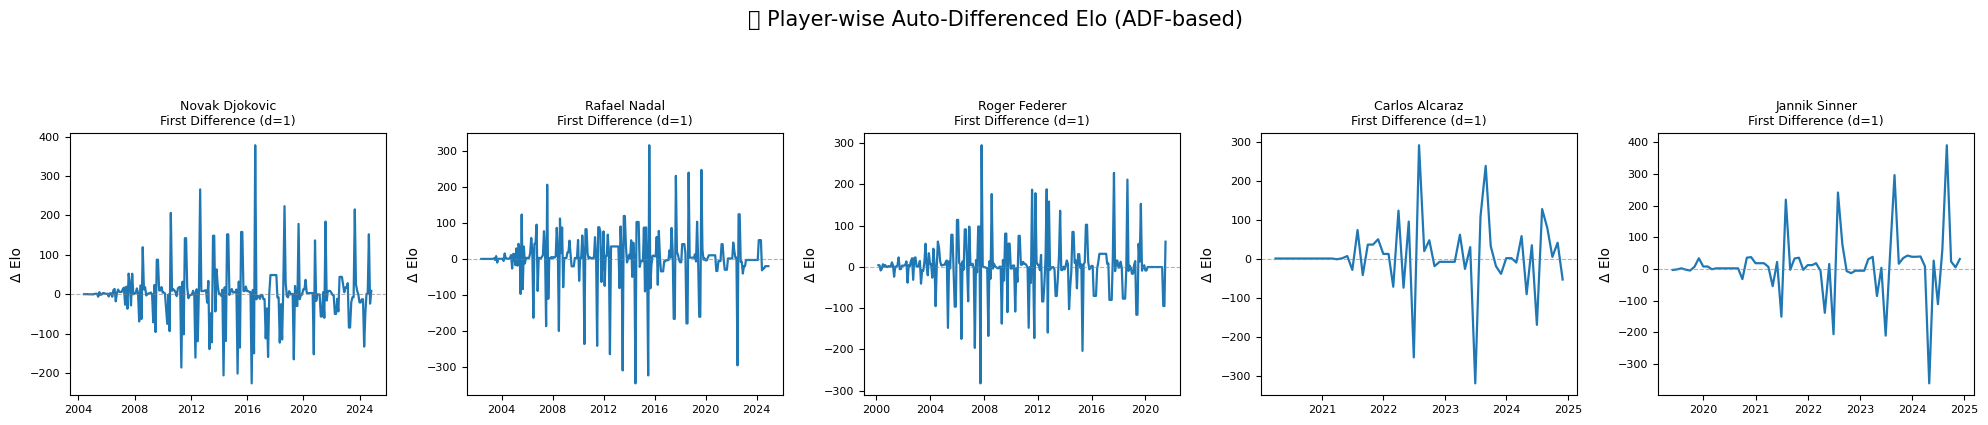


📊 Auto-differencing summary
────────────────────────────
Player             d     Trend
Novak Djokovic     1     False
Rafael Nadal       1     False
Roger Federer      1     False
Carlos Alcaraz     1     False
Jannik Sinner      1     False


In [12]:
# ===========================================================
# 🎾 PLAYER-WISE AUTO DIFFERENCING (ADF-based — Smarter + Summary)
# ===========================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller

players = [
    "Novak Djokovic", "Rafael Nadal", "Roger Federer",
    "Carlos Alcaraz", "Jannik Sinner"
]

# ===========================================================
# AUTO DIFFERENCING LOGIC (ADF-based — Smarter + Trend-aware)
# ===========================================================
def auto_diff_level(y, max_diff=2, sig=0.05):
    """
    Automatically determine differencing order (d) and whether a linear trend should be added.

    Logic:
      • Uses sequential ADF tests (up to max_diff) for stationarity
      • Detects deterministic trend via Pearson correlation with time index
      • Prevents over-differencing for short or trending series

    Returns:
        d (int): differencing order (0–2)
        trend_flag (bool): True if deterministic trend detected
    """
    y = pd.Series(y).dropna()

    # --- Step 1: Sequential ADF test ---
    for d in range(max_diff + 1):
        test_series = y.diff(d).dropna() if d > 0 else y
        try:
            pval = adfuller(test_series, autolag="AIC")[1]
            if pval < sig:
                break  # Stationarity achieved
        except Exception:
            continue
    else:
        d = max_diff

    # --- Step 2: Deterministic trend check ---
    try:
        t = np.arange(len(y))
        corr = abs(stats.pearsonr(t[-len(test_series):], test_series)[0]) if len(test_series) > 10 else 0
    except Exception:
        corr = 0
    trend_flag = corr > 0.25  # slightly more sensitive than 0.3

    # --- Step 3: Prevent over-differencing ---
    
    if len(y) < 80 and d > 1:
        d = 1
    if d == 2 and trend_flag:
        d = 1

    return d, trend_flag


# -----------------------------------------------------------
# BUILD FIRST / SECOND DIFFERENCE BASED ON AUTO_DIFF_LEVEL
# -----------------------------------------------------------
def make_auto_diff(player):
    """Compute differenced series per player based on ADF results."""
    y = player_monthly_elo[player].dropna()
    d, trend_flag = auto_diff_level(y)

    # 🔹 Apply differencing
    if d == 0:
        y_trans = y
        label = "Original (d=0)"
    elif d == 1:
        y_trans = y.diff().dropna()
        label = "First Difference (d=1)"
    else:
        y_trans = y.diff().diff().dropna()
        label = "Second Difference (d=2)"

    return pd.DataFrame({"date": y_trans.index, "value": y_trans.values}), label, trend_flag


# -----------------------------------------------------------
# PLOT ALL PLAYERS (AUTO DIFFERENCED)
# -----------------------------------------------------------
plt.style.use("default")
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("🎾 Player-wise Auto-Differenced Elo (ADF-based)", fontsize=15, y=1.05)
color = "#1f77b4"

for ax, player in zip(axes, players):
    df, label, trend_flag = make_auto_diff(player)
    ax.plot(df["date"], df["value"], color=color, linewidth=1.6)
    trend_note = " + trend" if trend_flag else ""
    ax.set_title(f"{player}\n{label}{trend_note}", fontsize=9)
    ax.axhline(0, color="gray", lw=0.8, ls="--", alpha=0.6)
    ax.set_xlabel("")
    ax.set_ylabel("Δ Elo" if "Diff" in label else "Elo")
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# -----------------------------------------------------------
# SUMMARY TABLE (d and trend decision)
# -----------------------------------------------------------
print("\n📊 Auto-differencing summary")
print("────────────────────────────")
print("Player".ljust(18), "d".ljust(5), "Trend")
for p in players:
    y = player_monthly_elo[p].dropna()
    d, tflag = auto_diff_level(y)
    print(p.ljust(18), str(d).ljust(5), tflag)


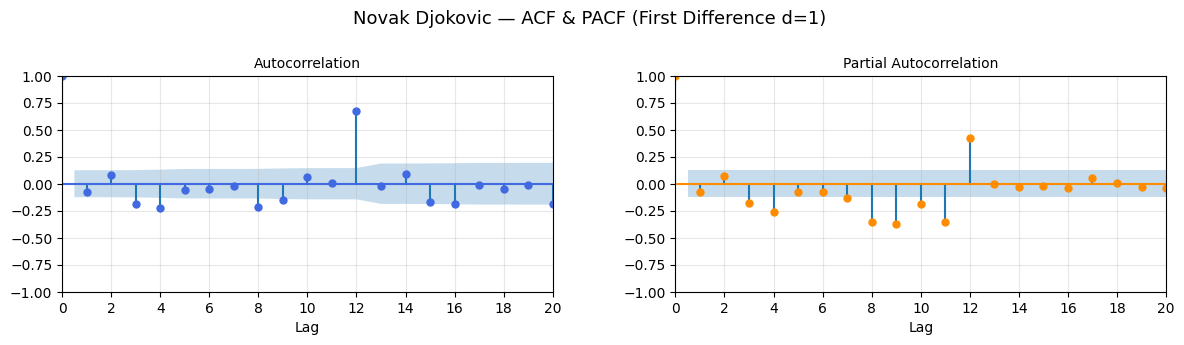

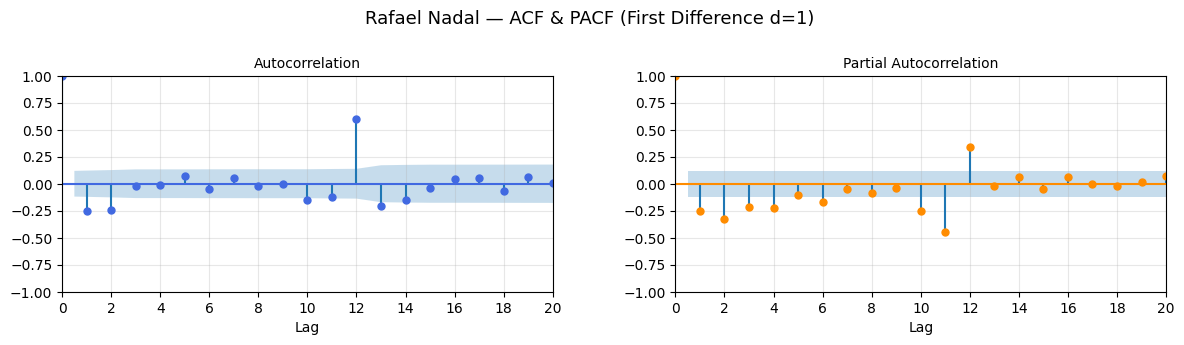

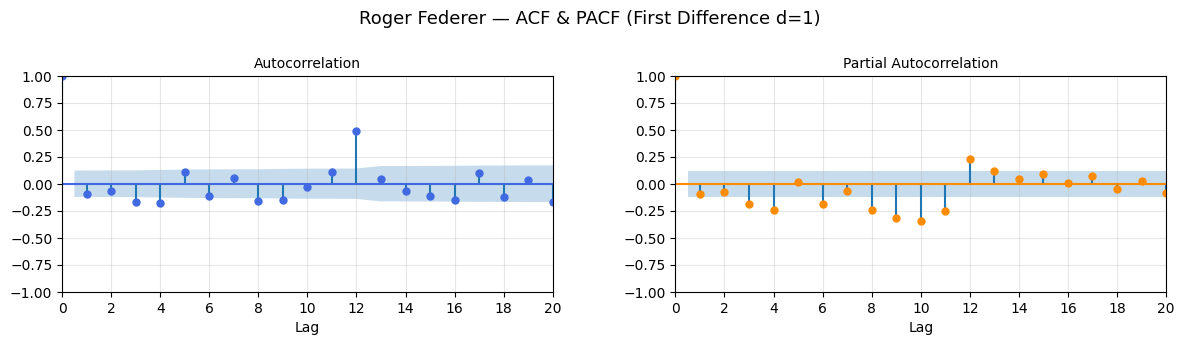

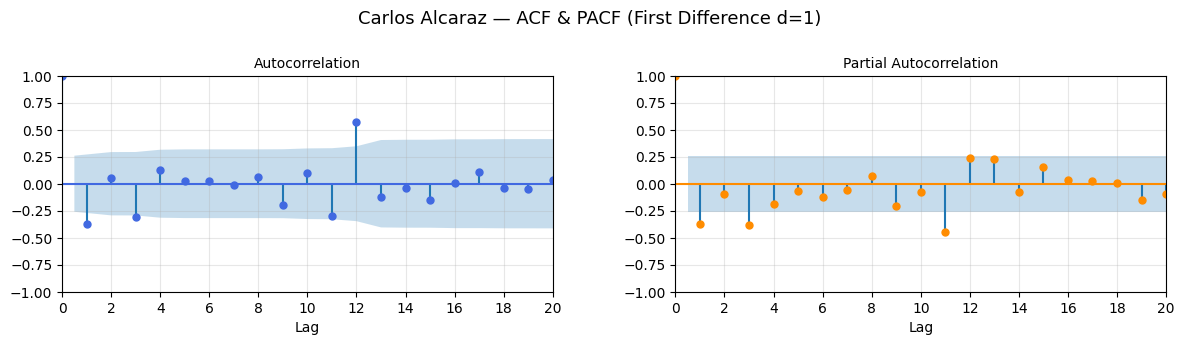

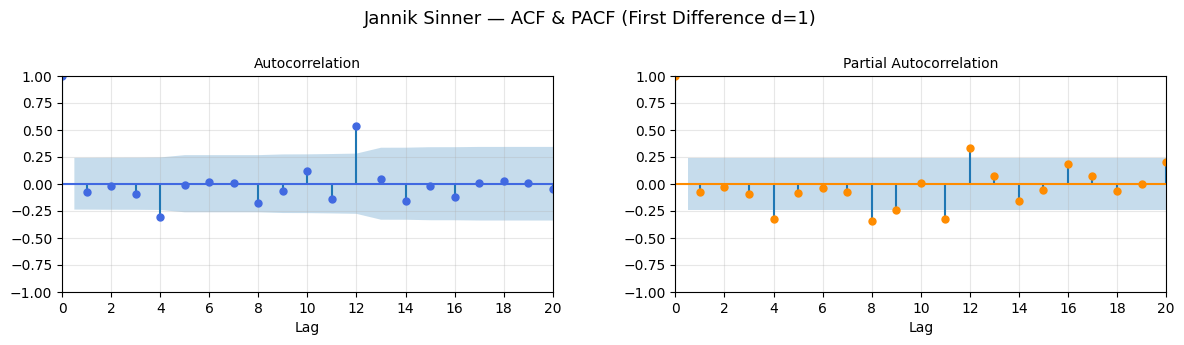

In [13]:
# ===========================================================
# 🎾 COMPACT ACF & PACF VISUALIZATION (First Difference Only)
# ===========================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

players = [
    "Novak Djokovic", "Rafael Nadal", "Roger Federer",
    "Carlos Alcaraz", "Jannik Sinner"
]

# ---------- ACF & PACF Plot Function ----------
def plot_acf_pacf(player, series):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(f"{player} — ACF & PACF (First Difference d=1)", fontsize=13, y=1.05)

    # --- ACF ---
    plot_acf(series, lags=20, ax=axes[0], color="royalblue")
    axes[0].set_title("Autocorrelation", fontsize=10)
    axes[0].set_xlabel("Lag")
    axes[0].set_ylim(-1, 1)
    axes[0].set_yticks(np.arange(-1, 1.25, 0.25))
    axes[0].set_xlim(0, 20)
    axes[0].set_xticks(np.arange(0, 21, 2))
    axes[0].xaxis.set_major_formatter('{:.0f}'.format)
    axes[0].grid(alpha=0.3)

    # --- PACF ---
    plot_pacf(series, lags=20, ax=axes[1], color="darkorange", method="ywm")
    axes[1].set_title("Partial Autocorrelation", fontsize=10)
    axes[1].set_xlabel("Lag")
    axes[1].set_ylim(-1, 1)
    axes[1].set_yticks(np.arange(-1, 1.25, 0.25))
    axes[1].set_xlim(0, 20)
    axes[1].set_xticks(np.arange(0, 21, 2))
    axes[1].xaxis.set_major_formatter('{:.0f}'.format)
    axes[1].grid(alpha=0.3)

    # 🔧 Spacing tuned to match Streamlit layout
    fig.subplots_adjust(wspace=0.25, top=0.83, left=0.06, right=0.98)
    plt.show()

# ===========================================================
# LOOP — All Players, First Differencing
# ===========================================================
for player in players:
    y = player_monthly_elo[player].dropna().diff().dropna()
    plot_acf_pacf(player, y)


In [14]:
# ===========================================================
# SMART MODEL EVALUATION PRO (parsimonious + interpretable + stable)
# ===========================================================

import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning


# -----------------------------------------------------------
# SMART MODEL EVALUATION FUNCTION
# -----------------------------------------------------------
def smart_evaluate_models(y, p_values, q_values):
    results = []

    # Auto-select differencing order + trend flag
    d, trend_flag = auto_diff_level(y)
    trend = 't' if trend_flag else 'n'

    for p in p_values:
        for q in q_values:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                try:
                    fit = ARIMA(y, order=(p, d, q), trend=trend).fit()
                    resid = fit.resid.dropna()

                    # 📈 Residual diagnostics
                    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
                    in_rmse = np.sqrt(np.mean(resid**2))

                    # 🧠 Stability filter — skip if either non-converged OR warned
                    converged = fit.mle_retvals.get("converged", True)
                    warned = any(isinstance(x.message, ConvergenceWarning) for x in w)
                    if not converged or warned:
                        continue  # 🚫 Skip if both condition fails

                    results.append({
                        "p": p, "d": d, "q": q,
                        "trend": trend,
                        "params": len(fit.params),
                        "AIC": fit.aic,
                        "BIC": fit.bic,
                        "RMSE_in": in_rmse,
                        "LB_p(10)": lb_p
                    })

                except Exception:
                    continue

    # 🧾 Collect results
    df = pd.DataFrame(results)
    if df.empty:
        print(f"⚠️ No models fit successfully for d={d}, trend={trend}")
        return df
    # 🧮 Ljung–Box sanity filter (relaxed for monthly Elo)
    df = df[df["LB_p(10)"] > 0.05].copy()
    if df.empty:
        print(f"⚠️ All models filtered out by Ljung–Box (p <= 0.05)")
        return df

    # 🧩 Ranking & SmartScore
    df["AIC_rank"] = df["AIC"].rank(ascending=True)
    df["BIC_rank"] = df["BIC"].rank(ascending=True)
    df["params_rank"] = df["params"].rank(ascending=True)
    df["RMSE_rank"] = df["RMSE_in"].rank(ascending=True)
    df["LB_rank"] = df["LB_p(10)"].rank(ascending=False)

    df["SmartScore"] = (
        0.40 * df["AIC_rank"]
        + 0.20 * df["BIC_rank"]
        + 0.10 * df["params_rank"]
        + 0.25 * df["RMSE_rank"]
        + 0.05 * df["LB_rank"]
    )

    df = df.sort_values("SmartScore").reset_index(drop=True).round(3)
    return df


# -----------------------------------------------------------
# RUN MODEL SELECTION (AUTO-d + AUTO-trend)
# -----------------------------------------------------------
p_values = [0, 1, 2, 3, 6, 12]
q_values = [0, 1, 2, 3, 6, 12]

for player in ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Carlos Alcaraz", "Jannik Sinner"]:
    y = player_monthly_elo[player].dropna()

    grid = smart_evaluate_models(y, p_values=p_values, q_values=q_values)

    print(f"\n📊 {player} — SMART Model Selection (Auto-d, Auto-trend)")
    if not grid.empty:
        print(grid.head(8))
        best = grid.iloc[0]
        print(
            f"🏆 Best: ARIMA({int(best.p)},{int(best.d)},{int(best.q)}) | "
            f"AIC={best.AIC:.2f}, BIC={best.BIC:.2f}, RMSE={best.RMSE_in:.3f}, "
            f"LB_p={best['LB_p(10)']:.3f}, Trend={best.trend}"
        )
    else:
        print("⚠️ No stable models found.")



📊 Novak Djokovic — SMART Model Selection (Auto-d, Auto-trend)
    p  d   q trend  params       AIC       BIC  RMSE_in  LB_p(10)  AIC_rank  \
0  12  1   0     n      13  2632.354  2677.923  106.648     1.000       1.0   
1   0  1  12     n      13  2693.927  2739.496  109.716     1.000       2.0   
2   2  1   3     n       6  2738.326  2759.358  113.407     0.774       3.0   
3   3  1   2     n       6  2739.669  2760.701  113.496     0.835       4.0   
4   1  1   6     n       8  2752.348  2780.391  114.172     0.999       5.0   
5   3  1   1     n       5  2756.906  2774.433  114.955     0.994       7.0   
6   6  1   1     n       8  2753.313  2781.356  114.246     0.991       6.0   
7   1  1   3     n       5  2762.866  2780.392  115.412     0.988       9.0   

   BIC_rank  params_rank  RMSE_rank  LB_rank  SmartScore  
0       1.0         20.5        1.0      1.0        2.95  
1       2.0         20.5        2.0      2.0        3.85  
2       3.0         14.5        3.0     21.0    


🔎 Novak Djokovic — ARIMA(12, 1, 0)
Mean of residuals: 12.2318
Std of residuals : 106.1596

Ljung–Box Test (H₀: No autocorrelation)
    lb_stat  lb_pvalue
10   0.1592        1.0
20   0.5441        1.0


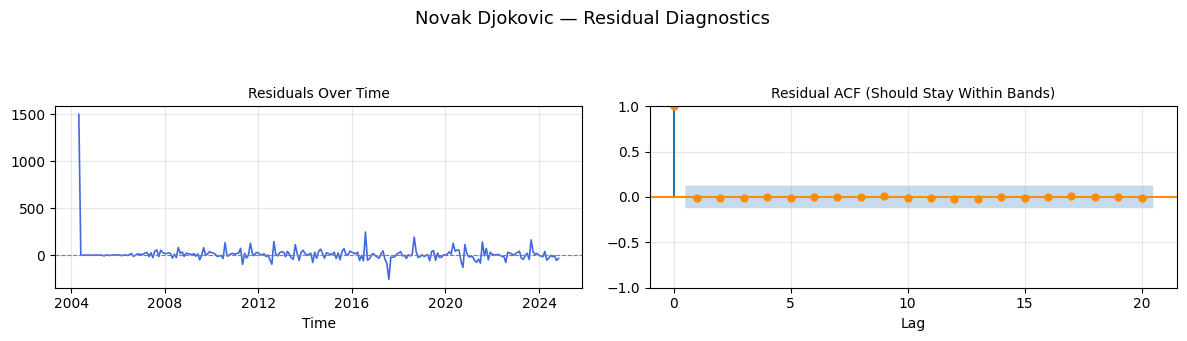


🔎 Rafael Nadal — ARIMA(12, 1, 0)
Mean of residuals: 11.9578
Std of residuals : 104.7409

Ljung–Box Test (H₀: No autocorrelation)
    lb_stat  lb_pvalue
10   0.2377        1.0
20   0.7612        1.0


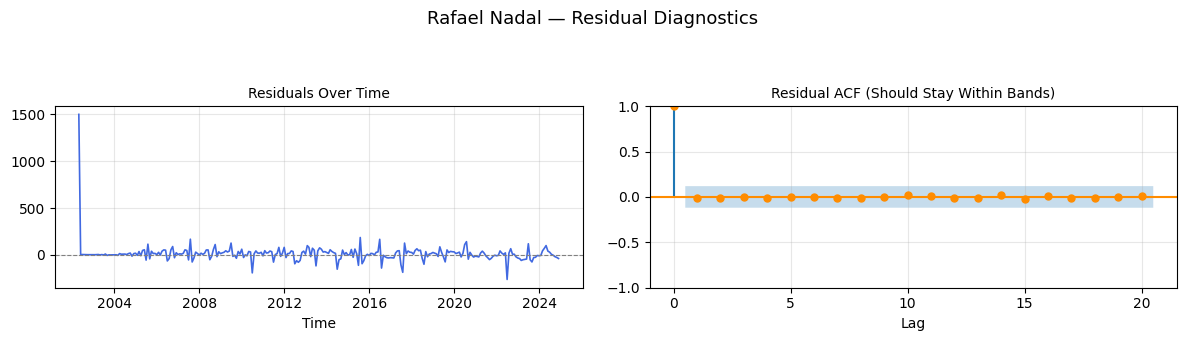


🔎 Roger Federer — ARIMA(12, 1, 0)
Mean of residuals: 13.7245
Std of residuals : 104.8223

Ljung–Box Test (H₀: No autocorrelation)
    lb_stat  lb_pvalue
10   0.1042        1.0
20   0.6161        1.0


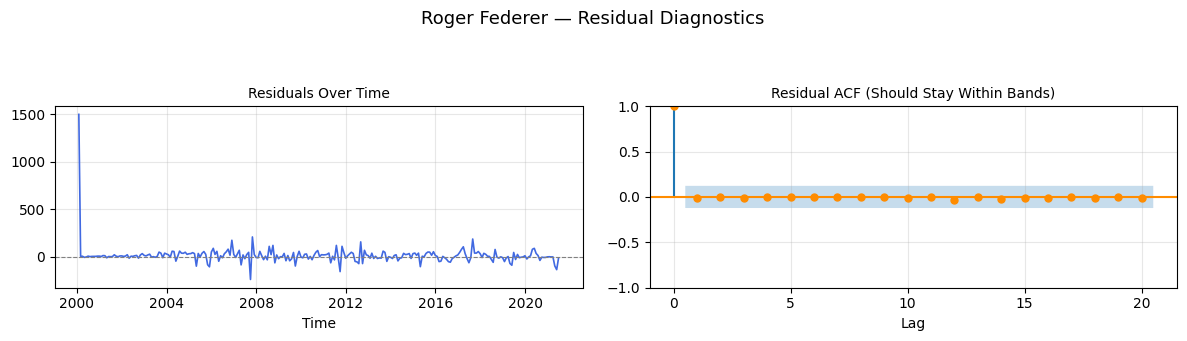


🔎 Carlos Alcaraz — ARIMA(2, 1, 3)
Mean of residuals: 42.4938
Std of residuals : 206.1926

Ljung–Box Test (H₀: No autocorrelation)
    lb_stat  lb_pvalue
10   0.2125        1.0
20   0.8832        1.0


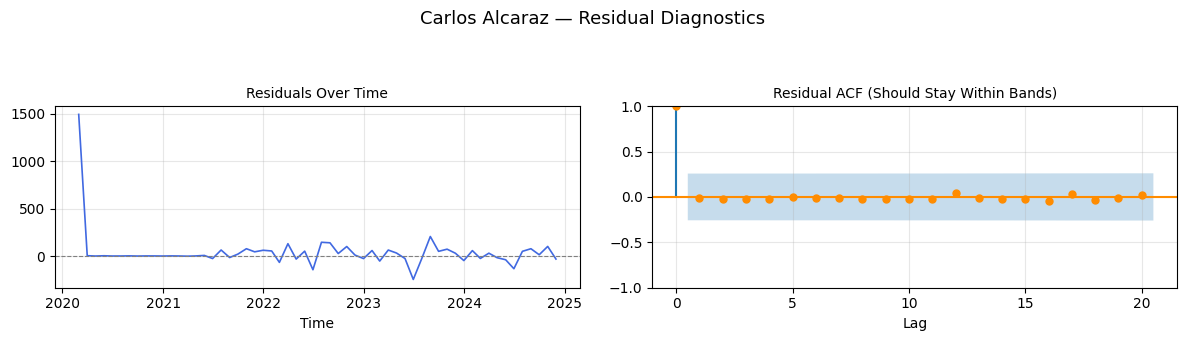


🔎 Jannik Sinner — ARIMA(3, 1, 2)
Mean of residuals: 38.5921
Std of residuals : 198.2284

Ljung–Box Test (H₀: No autocorrelation)
    lb_stat  lb_pvalue
10   0.4750        1.0
20   1.5124        1.0


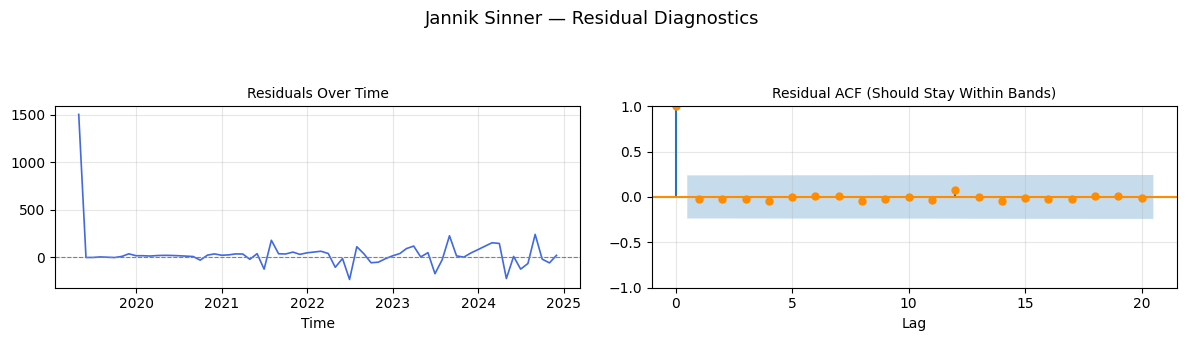

In [15]:
# -----------------------------------------------------------
# Residual diagnostics helper
# -----------------------------------------------------------
def residual_diagnostics(y, order, player, trend=None):
    """
    Fit ARIMA, print key stats, run Ljung–Box test,
    and plot residual diagnostics cleanly.
    """
    trend_label = " + Linear Trend" if trend == 't' else ""
    print(f"\n🔎 {player} — ARIMA{order}{trend_label}")

    # --- Fit model ---
    model = ARIMA(y, order=order, trend=trend)
    result = model.fit()
    resid = result.resid.dropna()

    # --- Summary stats ---
    print(f"Mean of residuals: {resid.mean():.4f}")
    print(f"Std of residuals : {resid.std():.4f}")

    # --- Ljung–Box test ---
    lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
    print("\nLjung–Box Test (H₀: No autocorrelation)")
    print(lb.round(4))

    # --- Plot residual diagnostics ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.2))

    # Residuals over time
    axes[0].plot(resid, color="royalblue", lw=1.2)
    axes[0].axhline(0, ls="--", c="gray", lw=0.8)
    axes[0].set_title("Residuals Over Time", fontsize=10)
    axes[0].set_xlabel("Time")
    axes[0].grid(alpha=0.3)

    # ACF of residuals
    plot_acf(resid, lags=20, ax=axes[1], color="darkorange")
    axes[1].set_title("Residual ACF (Should Stay Within Bands)", fontsize=10)
    axes[1].set_xlabel("Lag")
    axes[1].grid(alpha=0.3)

    plt.suptitle(f"{player} — Residual Diagnostics", fontsize=13, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return result


# -----------------------------------------------------------
# Run diagnostics automatically for each player
# -----------------------------------------------------------
players = ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Carlos Alcaraz", "Jannik Sinner"]

fitted_results = {}

for player in players:
    y = player_monthly_elo[player].dropna()

    # Automatically determine differencing + trend
    d, trend_flag = auto_diff_level(y)
    trend = 't' if trend_flag else None

    # Use ARIMA(p,q) structure around your previously selected best models
    # (For simplicity, try a moderate grid: pick best p,q from your SmartScore table)
    if player == "Novak Djokovic":
        order = (12, d, 0)
    elif player == "Rafael Nadal":
        order = (12, d, 0)
    elif player == "Roger Federer":
        order = (12, d, 0)
    elif player == "Carlos Alcaraz":
        order = (2, d, 3)
    else:  # Jannik Sinner
        order = (3, d, 2)

    fitted_results[player] = residual_diagnostics(y, order, player, trend)

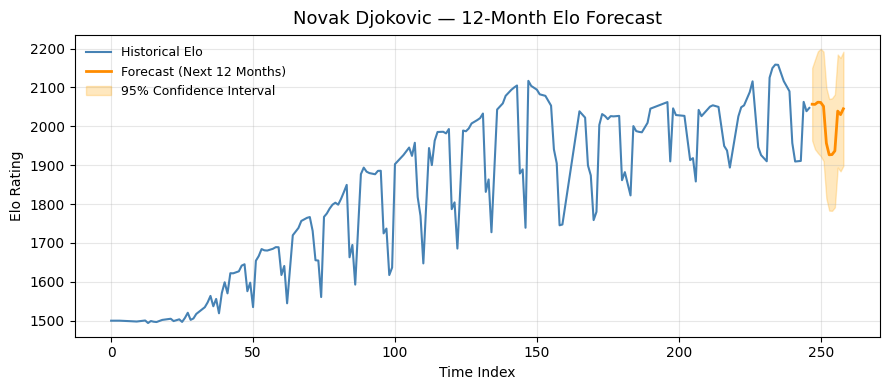

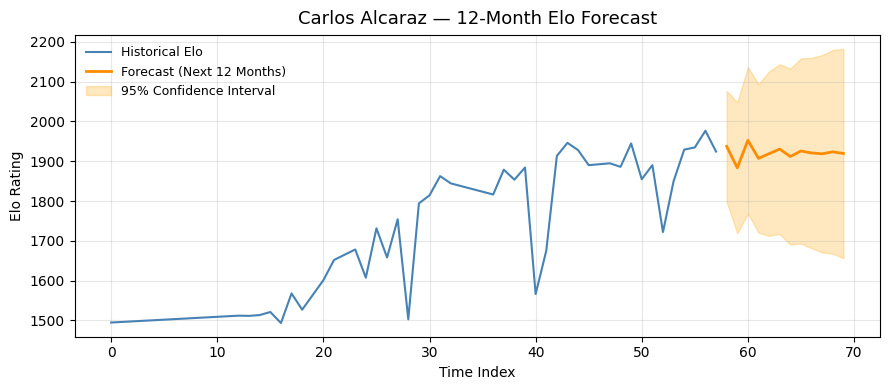

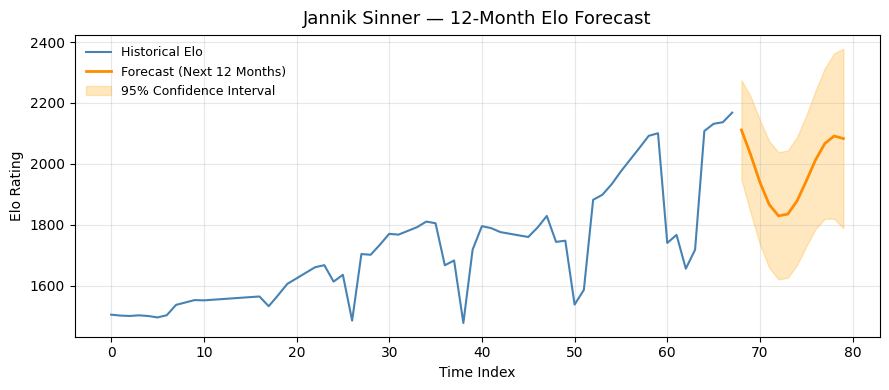


✅ Combined 12-Month Forecast Results:


,Player,Month_Ahead,Forecast_Elo,Lower_CI,Upper_CI,RMSE_out
0,Novak Djokovic,1,2056.907827,1963.450060,2150.365595,49.872407
1,Novak Djokovic,2,2056.472985,1941.230955,2171.715014,49.872407
2,Novak Djokovic,3,2062.172440,1931.496576,2192.848303,49.872407
3,Novak Djokovic,4,2061.454429,1923.436917,2199.471941,49.872407
4,Novak Djokovic,5,2051.593669,1910.797895,2192.389443,49.872407
5,Novak Djokovic,6,1956.881602,1814.668375,2099.094829,49.872407
6,Novak Djokovic,7,1926.764399,1783.278025,2070.250773,49.872407
7,Novak Djokovic,8,1927.422456,1782.599190,2072.245721,49.872407
8,Novak Djokovic,9,1936.893841,1791.683535,2082.104146,49.872407
9,Novak Djokovic,10,2039.326714,1893.897033,2184.756395,49.872407



📊 Model Summary with Out-of-Sample RMSE:


,Player,Order,Trend,AIC,BIC,RMSE_out
0,Novak Djokovic,"(12, 1, 0)",n,2632.35,2677.92,49.87
1,Carlos Alcaraz,"(2, 1, 3)",n,662.92,675.17,63.31
2,Jannik Sinner,"(3, 1, 2)",n,799.03,812.26,197.59


In [16]:
# ===========================================================
# STEP 7: 12-Month Forecasting for Active Players (2025–2026)
# ===========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forecast_horizon = 12  # months ahead
active_players = ["Novak Djokovic", "Carlos Alcaraz", "Jannik Sinner"]

forecast_df = []
meta_summary = []

for player in active_players:
    y = player_monthly_elo[player].dropna()
    model_fit = fitted_results[player]

    # --- Extract ARIMA order & trend from fitted model ---
    order = fitted_results[player].model.order
    trend = getattr(fitted_results[player].model, "trend", None)

    # --- Split train/test for out-of-sample evaluation ---
    split_idx = len(y) - forecast_horizon
    train, test = y.iloc[:split_idx], y.iloc[split_idx:]

    # --- Refit on training data only for OOS RMSE ---
    model_train = ARIMA(train, order=order, trend=trend).fit()
    fc_test = model_train.get_forecast(steps=len(test))
    pred_test = fc_test.predicted_mean
    rmse_oos = np.sqrt(np.mean((test.values - pred_test.values) ** 2))

    # --- Fit final model on full data for next 12-month forecast ---
    final_model = ARIMA(y, order=order, trend=trend).fit()
    forecast = final_model.get_forecast(steps=forecast_horizon)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int(alpha=0.05)

    # ---- Store forecasted values ----
    temp = pd.DataFrame({
        "Player": player,
        "Month_Ahead": np.arange(1, forecast_horizon + 1),
        "Forecast_Elo": mean_forecast.values,
        "Lower_CI": conf_int.iloc[:, 0].values,
        "Upper_CI": conf_int.iloc[:, 1].values,
        "RMSE_out": rmse_oos
    })
    forecast_df.append(temp)

    # ---- Meta summary ----
    meta_summary.append({
        "Player": player,
        "Order": order,
        "Trend": trend if trend else "None",
        "AIC": round(final_model.aic, 2),
        "BIC": round(final_model.bic, 2),
        "RMSE_out": round(rmse_oos, 2)
    })

    # ---- Plot Forecast ----
    fig, ax = plt.subplots(figsize=(9, 4))
    hist = y.values
    hist_idx = np.arange(len(hist))
    fut_idx = np.arange(len(hist), len(hist) + forecast_horizon)

    ax.plot(hist_idx, hist, color="steelblue", label="Historical Elo", lw=1.5)
    ax.plot(fut_idx, mean_forecast, color="darkorange",
            label="Forecast (Next 12 Months)", lw=2.0)
    ax.fill_between(fut_idx, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                    color="orange", alpha=0.25, label="95% Confidence Interval")
    ax.set_title(f"{player} — 12-Month Elo Forecast", fontsize=13, pad=8)
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Elo Rating")
    ax.legend(frameon=False, fontsize=9)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---- Combine results ----
forecast_df = pd.concat(forecast_df, ignore_index=True)
meta_summary_df = pd.DataFrame(meta_summary)

print("\n✅ Combined 12-Month Forecast Results:")
display(forecast_df.head(20))

print("\n📊 Model Summary with Out-of-Sample RMSE:")
display(meta_summary_df)


,Matchup,Elo_A,Elo_B,P(A_wins),P(B_wins),Favorite
0,Novak Djokovic vs Carlos Alcaraz,2056.907827,1937.230734,0.666,0.334,Novak Djokovic
1,Novak Djokovic vs Jannik Sinner,2056.907827,2111.077833,0.423,0.577,Jannik Sinner
2,Carlos Alcaraz vs Jannik Sinner,1937.230734,2111.077833,0.269,0.731,Jannik Sinner


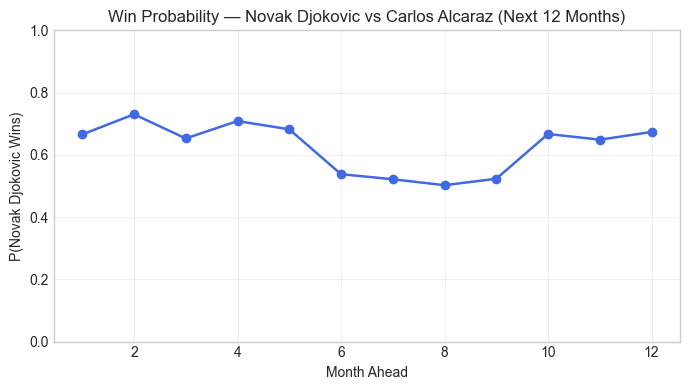

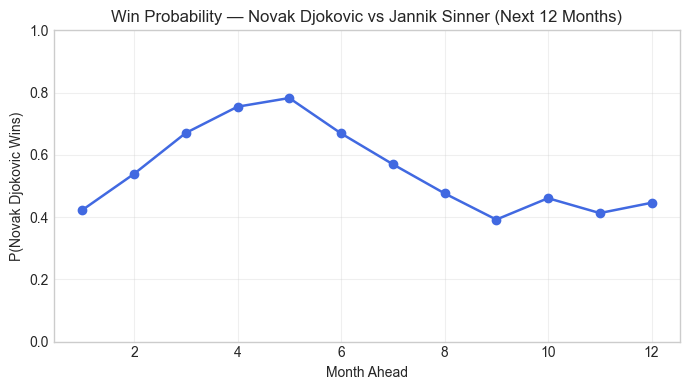

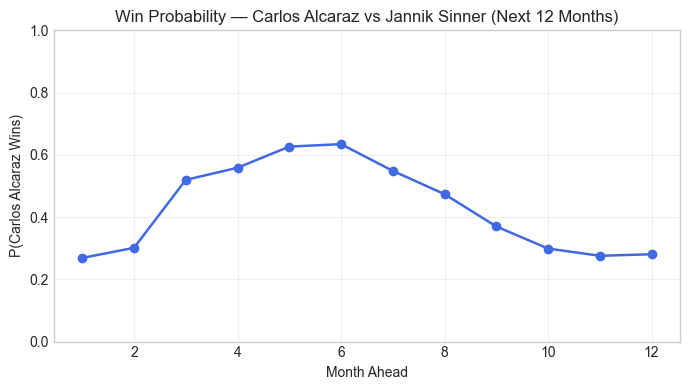

In [17]:
# ===========================================================
# Projected Matchup Probabilities (Elo → Win %)
# ===========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
active_players = ["Novak Djokovic", "Carlos Alcaraz", "Jannik Sinner"]
forecast_horizon = 12  # months ahead

# --- Helper: Elo → Win Probability ---
def elo_win_prob(elo_a, elo_b):
    """Return probability that player A beats player B."""
    return 1.0 / (1.0 + 10 ** (-(elo_a - elo_b) / 400.0))

# --- Ensure Forecasts Exist ---
need_forecast = (
    "forecast_df" not in globals() 
    or forecast_df["Month_Ahead"].max() < forecast_horizon
)
if need_forecast:
    forecast_df = []
    for player in active_players:
        model = fitted_results[player]
        fc = model.get_forecast(steps=forecast_horizon)
        mean_fc = fc.predicted_mean
        ci = fc.conf_int()
        tmp = pd.DataFrame({
            "Player": player,
            "Month_Ahead": np.arange(1, forecast_horizon + 1),
            "Forecast_Elo": mean_fc.values,
            "Lower_CI": ci.iloc[:, 0].values,
            "Upper_CI": ci.iloc[:, 1].values
        })
        forecast_df.append(tmp)
    forecast_df = pd.concat(forecast_df, ignore_index=True)

# --- Pivot to Wide Format ---
elo_wide = (
    forecast_df
    .pivot(index="Month_Ahead", columns="Player", values="Forecast_Elo")
    .reindex(range(1, forecast_horizon + 1))
)
elo_wide = elo_wide[active_players]  # preserve order

# --- Compute Pairwise Probabilities ---
pairs = [
    ("Novak Djokovic", "Carlos Alcaraz"),
    ("Novak Djokovic", "Jannik Sinner"),
    ("Carlos Alcaraz", "Jannik Sinner"),
]

rows = []
for m in elo_wide.index:
    for a, b in pairs:
        ea, eb = elo_wide.loc[m, a], elo_wide.loc[m, b]
        p_a = elo_win_prob(ea, eb)
        rows.append({
            "Month_Ahead": m,
            "Matchup": f"{a} vs {b}",
            "Elo_A": ea, "Elo_B": eb,
            "P(A_wins)": p_a,
            "P(B_wins)": 1 - p_a,
            "Favorite": a if p_a >= 0.5 else b
        })
prob_table = pd.DataFrame(rows)

# --- Next-Month Snapshot ---
next_month = prob_table[prob_table["Month_Ahead"] == 1].copy()
next_month["P(A_wins)"] = next_month["P(A_wins)"].round(3)
next_month["P(B_wins)"] = next_month["P(B_wins)"].round(3)
display(next_month[["Matchup", "Elo_A", "Elo_B", "P(A_wins)", "P(B_wins)", "Favorite"]])

# ===========================================================
# Win Probability Trajectories — All Key Matchups
# ===========================================================

plt.style.use("seaborn-v0_8-whitegrid")

for plot_pair in pairs:
    subset = prob_table[prob_table["Matchup"] == f"{plot_pair[0]} vs {plot_pair[1]}"]

    plt.figure(figsize=(7, 4))
    plt.plot(subset["Month_Ahead"], subset["P(A_wins)"],
             marker="o", color="royalblue", lw=1.8)
    plt.ylim(0, 1)
    plt.title(f"Win Probability — {plot_pair[0]} vs {plot_pair[1]} (Next {forecast_horizon} Months)")
    plt.xlabel("Month Ahead")
    plt.ylabel(f"P({plot_pair[0]} Wins)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

